In [126]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter

# CONSTANTES
n = 28 # Taille de l'image
N = 4 # Nombre d'image
k = 26 # Nombre de lettre a reconnaitre

# Fonction qui importe une image, la redimenssionne et la binarize
def impIm(lettre,num):
    im = np.array(Image.open("sources/%s%d.png" % (lettre,num)).resize((n,n)))
    th = 128
    im_bool = (im < th) 

    # Passage de matrice RGB a matrice 2D
    matx = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if im_bool[i,j,0]:
                matx[i,j] = 1
            else:
                matx[i,j] = 0
    return matx

# Fonction d'apprentissage machine, elle fait ressortir les zone les plus occupe d'une matrice
def learn(mat):
    for i in range(n):
        for j in range(n):
            if mat[i,j] == 1:
                mat[i,j] += 1
            else:
                mat[i,j] += -1
    return mat

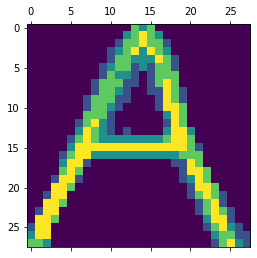

In [128]:
# On construit la matrice de poid W pour la lettre A
W = np.zeros((n,n))
for i in range(N):
    W += learn(impIm('A',i))
    
plt.matshow(W)

Q =  0.9114688128772637


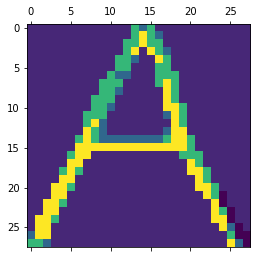

In [129]:
# SCORE CANDIDAT
I = impIm('A',0)
phi = W*I
plt.matshow(phi)

# SCORE IDEAL POID-MODEL
mu = 0
for i in range(n):
    for j in range(n):
        if W[i,j]> 0:
            mu += W[i,j]

# QUOTIENT DE RECONNAISSANCE
Q = phi/mu
print("Q = ",abs(Q.sum()))

In [ ]:
alphabet = np.array(['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'])

I = impIm('test',0)

Wk = np.zeros((k,n,n))
for i in range(k):
    for j in range(N):
        Wk[i] += learn()
        
phik = np.zeros((k,n,n))
for i in range(k):
    phik[i] = Wk[i]*I

muk = np.zeros(k)
for i in range(k):
    for i in range(k):
        for j in range(n):
            for l in range(n):
                muk[i] += Wk[i,j,l]

Qk = np.zeros(k)
for i in range(k):
    Qk[i] = phik[i]/muk[i]

Wk[0] = np.ones(n)
print(Wk)

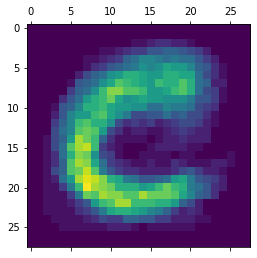

In [113]:
plt.matshow(Wk[2])

In [330]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import time

'''
Sources pour importer les donnees:
https://stackoverflow.com/questions/40427435/extract-images-from-idx3-ubyte-file-or-gzip-via-python
'''
start = time.time()

im_size = 28
num_images = 100000
N = num_images
k = 26

f = gzip.open('samples/emnist-letters-train-images-idx3-ubyte.gz', 'r') # importation de la base de donnees d'images de lettres
f.read(16)
buf = f.read( im_size * im_size * num_images) # buffer
data = np.frombuffer(buf, dtype = np.uint8).astype(np.float32) # Interpret a buffer as a 1-dimensional array.
data = data.reshape(num_images, im_size, im_size, 1) # reshape a la bonne taille    

def printim(ind):
    image = np.asarray(data[ind]).squeeze() # L'image n'est pas dans le bon sens
    image = np.fliplr(image) # Donc on la flip 
    image = np.rot90(image) # Et on la tourne de 90 degres
    #plt.imshow(image) # Pour que l'image soit dans le bon sens
    #plt.show()
    return image

def readim(num):
    im = printim(num)
    th = 128
    im_bool = (im > th) 
    mat = np.zeros((im_size, im_size))
    # Passage de matrice RGB a matrice 2D
    for i in range(len(im)):
        for j in range(len(im)):
            if im_bool[i,j]:
                mat[i,j] = 1
            else:
                mat[i,j] = 0
    return mat

def learn(mat):
    for i in range(im_size):
        for j in range(im_size):
            if mat[i,j] == 1:
                mat[i,j] += 1
            else:
                mat[i,j] += -1
    return mat

alphabet = np.array(['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'])
labels = np.zeros(N+1)
tabalph = np.zeros(N+1, dtype=str)

f = gzip.open('samples/emnist-letters-train-labels-idx1-ubyte.gz','r') # importation de la base de donnees de labels de lettres
# Le code ci dessous va lire la base de donnee et renvoyer la lettre afficher a l'ecran
f.read(8)
for i in range(0,N+1):   
    buf = f.read(1)
    labels[i] = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    tabalph[i] = alphabet[int(labels[i]) - 1]

Wk = np.zeros((k,im_size,im_size))
for i in range(num_images):
    Wk[int(labels[i]) - 1] += learn(printim(i))
    
I = learn(readim(22))
phik = np.zeros(k)
for i in range(k):
    for j in range(im_size):
        for l in range(im_size):
            phik[i] = Wk[i][j][l]*I[j][l]
    
muk = np.zeros(k)
for i in range(k):
    for j in range(im_size):
        for l in range(im_size):
            if Wk[i][j][l] > 0:
                muk[i] += Wk[i][j][l]

Qk = np.zeros(k)
for i in range(k):
    Qk[i] = phik[i]/muk[i]

end = time.time()
print(f"Temps d'execution du programme: {end - start} s") # Approximativement 1 minutes pour lire toutes les donnees avec num_image = 50 000

Temps d'execution du programme: 411.3513927459717 s


In [335]:
# Fonction renvoyant ce que le reseau de neuronnes pense etre la lettre la plus probable
def Q(lettre):
    I= learn(readim(lettre))
    #print(alphabet[int(labels[lettre])- 1])
    #print(int(labels[lettre]) - 1)
    phik = np.zeros(k)
    for i in range(k):
        for j in range(im_size):
            for l in range(im_size):
                phik[i] += Wk[i][j][l]*I[j][l]

    muk = np.zeros(k)
    for i in range(k):
        for j in range(im_size):
            for l in range(im_size):
                if Wk[i][j][l] > 0:
                    muk[i] += Wk[i][j][l]

    Qk = np.zeros(k)
    for i in range(k):
        Qk[i] = phik[i]/muk[i]
    return np.argmax(Qk)

In [336]:
# Test verifiant si le reseau de neuronnes est performant
Qstat = 0
for i in range(1000):
    if Q(i) == int(labels[i] - 1):
        Qstat += 1
        
print(Qstat/num_images)
# spoiler: il ne l'est pas du tout

0.00399
